In [2]:
# import libraries
import jax
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
try:
    import blackjax
except:
    %pip install -qq blackjax
    import blackjax
import matplotlib.pyplot as plt
import pickle
import os
import logging
import seaborn as sns
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())
key = jax.random.PRNGKey(5)

2022-06-15 23:50:47.875724: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [22]:
class LassoRegression():
    def __init__(self,noise_var=0):
        self.prior = None
        # self.no_samples = no_samples
        self.n_features = 0
        self.n_train = 0
        self.states = None
        self.noise_var = noise_var
    
    def identity_trans(self,x):
        return jnp.append(jnp.ones((x.shape[0],1)),x,axis=1)

    def log_postfn(self,params):
        log_prior_noise = 0
        noise_var = self.noise_var
        if('noise_var' in params):
            noise_var = params['noise_var']
            log_prior_noise = self.prior_noise.log_prob(noise_var)
        theta = params['theta']

        log_prior = jnp.sum(self.prior.log_prob(theta))
        # log_likelihood
        mean = (self.x_train@theta.reshape(self.n_features,1)).reshape(self.n_train,)
        likelihood_normal = tfd.MultivariateNormalFullCovariance(mean,noise_var*jnp.identity(self.n_train))
        log_like = jnp.array(likelihood_normal.log_prob(self.y_train))
        return (log_like+log_prior+log_prior_noise)

    
    def create_log_postfn(self,x_train,y_train,prior_mean,prior_var_diag,prior_alpha=None,prior_beta=None,ridge=False):
        self.n_train,self.n_features = x_train.shape  
        if(ridge==True):
            self.prior = tfd.Normal(loc = prior_mean,scale = prior_var_diag**0.5)
        else:
            self.prior = tfd.Laplace(loc = prior_mean,scale = prior_var_diag**0.5)
        if(prior_alpha!=None):
            self.prior_noise = tfd.InverseGamma(prior_alpha,prior_beta)
        self.y_train = y_train.reshape(self.n_train,)
        self.x_train = x_train
    
    def rmh_inference_loop(self, sigma_rmh, params, num_samples=10e4):
        rmh = blackjax.rmh(self.log_postfn, sigma= sigma_rmh)
        initial_state = rmh.init(params)
        def inference_loop(rng_key, kernel, initial_state, num_samples):
            @jax.jit
            def one_step(state, rng_key):
                state, _ = kernel(rng_key, state)
                return state, state

            keys = jax.random.split(rng_key, num_samples)
            _, states = jax.lax.scan(one_step, initial_state, keys)

            return states
        rng_key = jax.random.PRNGKey(0)
        _, rng_key = jax.random.split(rng_key)
        self.states = inference_loop(rng_key, rmh.step, initial_state, num_samples)
        return self.states
    
    def predict(self,x_test):
        burnin = self.states.position['theta'].shape[0]//3
        mean = (x_test@(self.states.position['theta'][burnin:,:].T))
        noise_var = self.noise_var
        if('noise_var' in self.states.position):
            noise_var = jnp.mean(self.states.position['theta'][burnin:,:])
        likelihood_normal = tfd.MultivariateNormalDiag(mean,noise_var*jnp.ones(mean.shape))
        samples = likelihood_normal.sample(seed = key)
        sample_mean = samples.mean(axis=1)
        sample_std = samples.std(axis=1)
        return sample_mean,sample_std

    def plot_rmh(self,burnin=None):
        if(burnin==None):
            burnin = self.states.position['theta'].shape[0]//3
        for key in self.states.position:
            if jnp.ndim(self.states.position[key])==1:
                fig, (ax,ax1) = plt.subplots(1,2,figsize=(13,5))
                ax.plot(self.states.position[key])
                ax.set_title('trace plot')
                ax.axvline(x=burnin, c="tab:red")
                ax1.hist(self.states.position[key],density=True)
                sns.kdeplot(self.states.position[key],ax=ax1)
                ax1.set_title("histogram")
                plt.suptitle(key,fontsize=20)
                try:
                    plt.savefig('figures/'+key+'.jpeg')
                except:
                    os.mkdir('figures')
                    plt.savefig('figures/'+key+'.jpeg')
                plt.show()
            
            else:
                for i in range(self.states.position[key].shape[1]):
                    fig, (ax,ax1) = plt.subplots(1,2,figsize=(8,3))
                    ax.plot(self.states.position[key][:,i])
                    ax.set_title('trace plot')
                    ax.axvline(x=burnin, c="tab:red")
                    ax1.hist(self.states.position[key][burnin:,i],density=True)
                    sns.kdeplot(self.states.position[key][burnin:,i],ax=ax1)
                    ax1.set_title("histogram")
                    plt.suptitle(key+str(i),fontsize=20)
                    try:
                        plt.savefig('figures/'+key+str(i)+'.jpeg')
                    except:
                        os.mkdir('figures')
                        plt.savefig('figures/'+key+str(i)+'.jpeg')
                    plt.show()


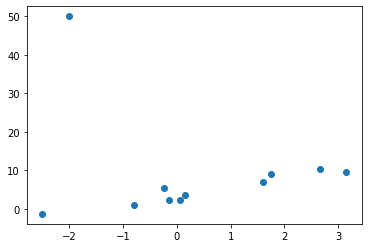

In [23]:

def poly_trans(x,deg):
    x_trans = jnp.ones((x.shape[0],1))
    for i in range(1,deg+1):
        x_trans = jnp.append(x_trans,x**i,axis=1)
    return x_trans

with open("linear_regression",'rb') as f:
    data = pickle.load(f)
x = jnp.array(data['data']['x'])
x = jnp.append(x,jnp.array([[-2,]]),axis=0)
m = x.shape[0]

deg = 4
x_trans = poly_trans(x,deg)
y = jnp.array(data['data']['y'])
y = jnp.append(y,jnp.array([[50,]]),axis=0)
prior_mean = jnp.zeros(x_trans.shape[1])
prior_var_diag = jnp.ones(x_trans.shape[1])*0.5
noise_var = data['noise_variance']
prior_alpha, prior_beta = data['prior']['alpha'],data['prior']['beta']
prior_alpha, prior_beta = 1,1
plt.scatter(x,y)

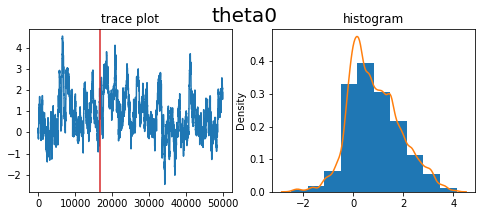

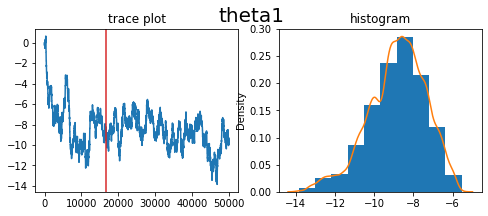

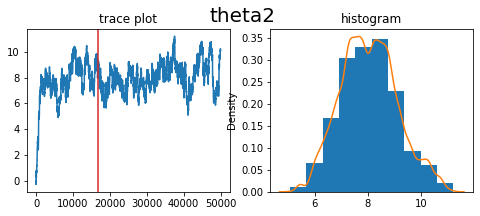

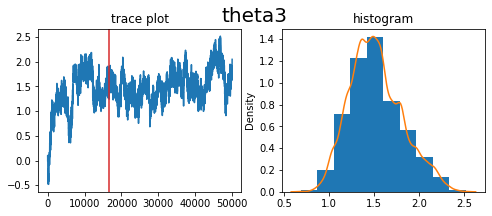

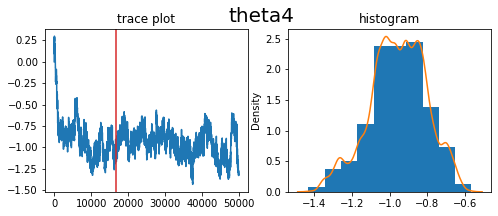

In [40]:
## usage:
noise_var = 10
model = LassoRegression(noise_var=noise_var)
model.create_log_postfn(x_trans,y,prior_mean,prior_var_diag,prior_alpha,prior_beta)
initial = {"theta":prior_mean}
sigma_shape = prior_mean.shape[0]
states = model.rmh_inference_loop(jnp.ones(sigma_shape)*0.2,initial,num_samples=50000)
model.plot_rmh()


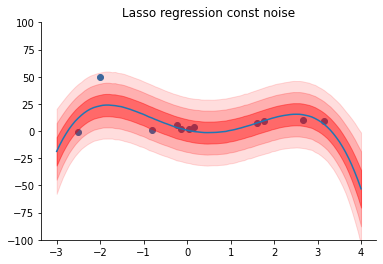

In [42]:
import seaborn as sns
def plot_predictive(x,sample_mean,sample_std,x_data,y_data,title="Unnamed"):
    fig,ax = plt.subplots()
    ax.scatter(x_data,y_data)
    ax.plot(x,sample_mean)
    for i in range(1,4):
        ax.fill_between(x,sample_mean+i*sample_std,sample_mean-i*sample_std,alpha=0.4/i,color="r" , label=str(i+1)+" std_dev")
    # plt.legend()
    plt.ylim(-100,100)
    plt.title(title)
    sns.despine()
    plt.savefig(title+".jpeg")
    plt.show()
    
x_test = jnp.linspace(-3,4,100)
x_trans_test = poly_trans(x_test.reshape((-1,1)),deg)
lasso_mean,lasso_std = model.predict(x_trans_test)
plot_predictive(x_test,lasso_mean,lasso_std,x,y,title="Lasso regression const noise")


In [43]:
initial = {"theta":prior_mean,'noise_var':10.1}

model.log_postfn(initial)

DeviceArray(-172.24255, dtype=float32)

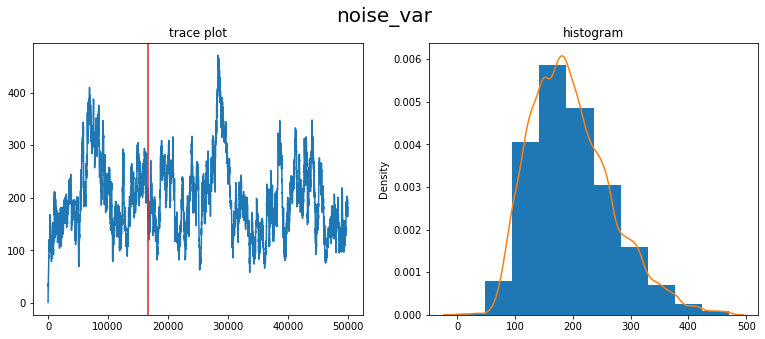

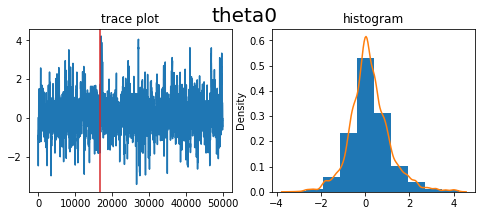

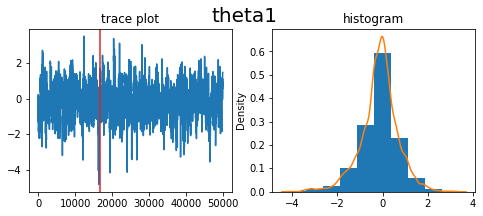

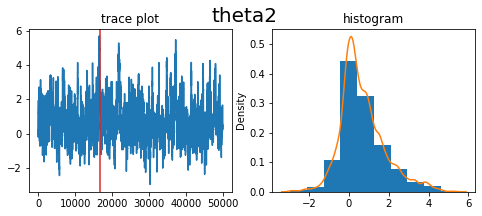

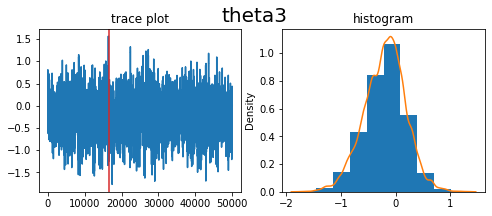

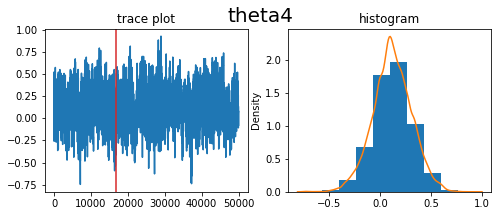

In [44]:
## usage:

model = LassoRegression()
model.create_log_postfn(x_trans,y,prior_mean,prior_var_diag,prior_alpha,prior_beta)

initial = {"theta":prior_mean,'noise_var':1}
sigma_shape = prior_mean.shape[0]+1
sigma = jnp.append(10,jnp.ones(sigma_shape-1)*0.5)
states = model.rmh_inference_loop(sigma,initial,num_samples=50000)
model.plot_rmh()


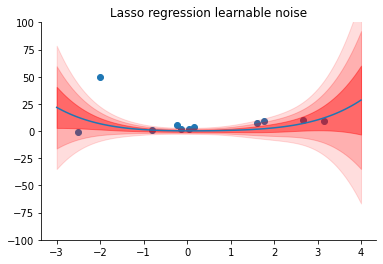

In [45]:
x_test = jnp.linspace(-3,4,100)

x_trans_test = poly_trans(x_test.reshape((-1,1)),deg)
lasso_mean,lasso_std = model.predict(x_trans_test)
plot_predictive(x_test,lasso_mean,lasso_std,x,y,title="Lasso regression learnable noise")

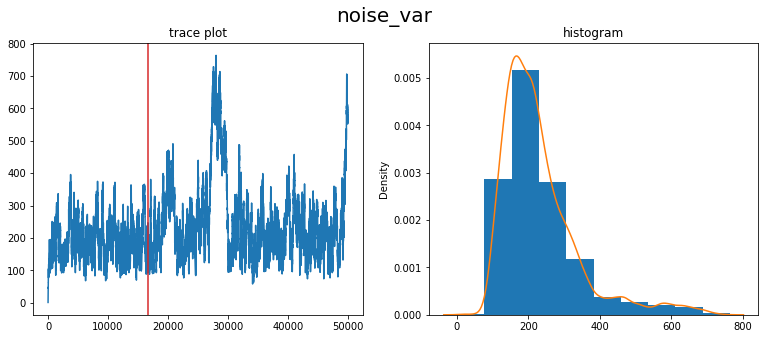

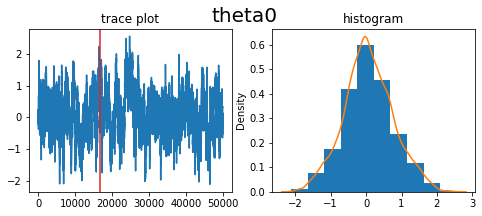

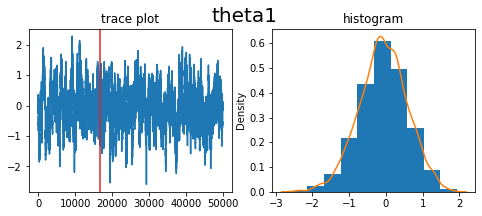

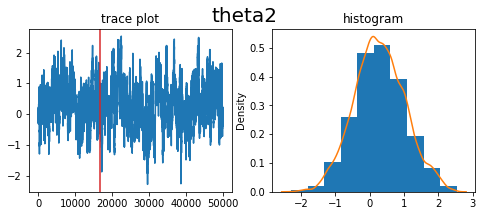

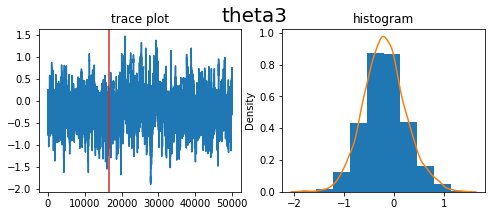

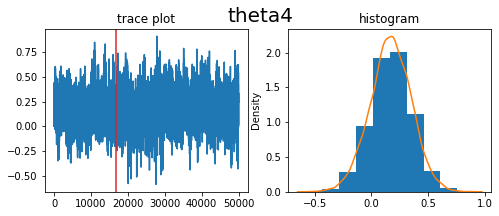

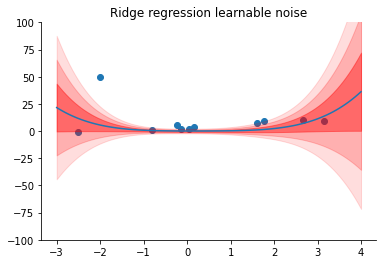

In [46]:
## usage:

model = LassoRegression()

prior_var_diag = jnp.ones(x_trans.shape[1])*0.5
model.create_log_postfn(x_trans,y,prior_mean,prior_var_diag,prior_alpha,prior_beta,ridge=True)

initial = {"theta":prior_mean,'noise_var':1}
sigma_shape = prior_mean.shape[0]+1
sigma = jnp.append(10,jnp.ones(sigma_shape-1)*0.1)
states = model.rmh_inference_loop(sigma,initial,num_samples=50000)
model.plot_rmh()

lasso_mean,lasso_std = model.predict(x_trans_test)
plot_predictive(x_test,lasso_mean,lasso_std,x,y,title="Ridge regression learnable noise")